# Machine Vision<br>Assignment 4 - Texture

## Personal details

* **Name(s):** `PUT YOUR NAME(S) HERE.`
* **Student ID(s):** `PUT YOUR STUDENT ID(S) HERE.`

## 1. Introduction

This assignment explores the use of Local Binary Patterns (LBP) for face recognition. There are a variety of use-cases for face recognition, including identity verification, human-computer interaction, desktop login and parental control. In this assignment, we will create a classifier that can determine to which of the training classes a given face belongs (Figure 1).

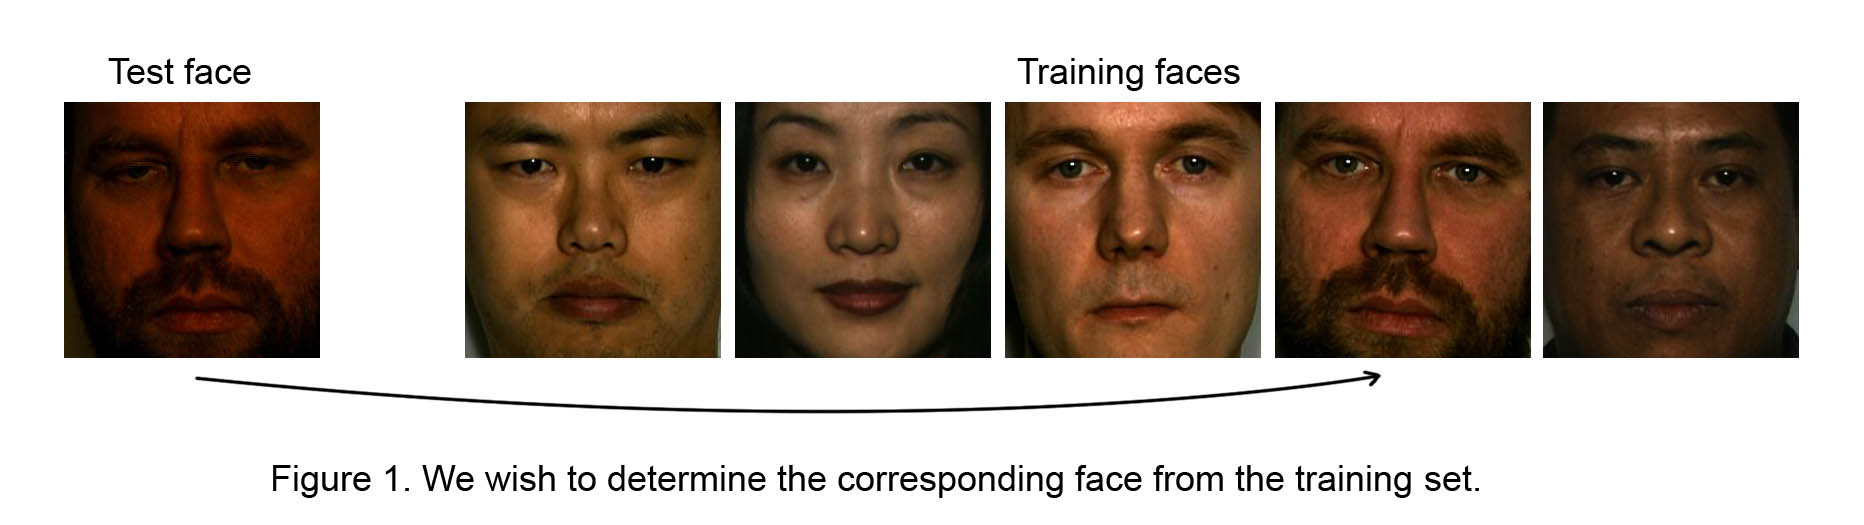

The folder `images/train/` contains five different face images that will be used to train the classifier. We first display the faces and compute the corresponding grayscale histograms. The histograms will be stored to 5 x 256 matrix `H` for later use.

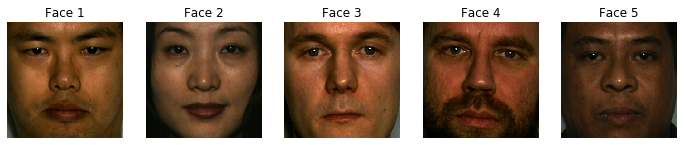

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Get file paths to training images
fnames_train = sorted(glob.glob('images/train/*.jpg'))

# Number of different training faces
N = len(fnames_train) 

# We will store grayscale histograms
H = np.zeros((N,256),dtype=float)

plt.figure(figsize=(12,5))

for i in range(0,N):
    
    img = cv2.imread(fnames_train[i])
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Display training faces (class labels: 0,1,2,3,4)
    plt.subplot(1,N,i+1)
    plt.imshow(rgb)
    plt.title('Face %d' %(i+1))
    plt.axis('off')
    
    # Compute grayscale histogram for later use
    H[i,:] = np.histogram(gray.ravel(),256,density=True)[0]


The folder `images/test/` contains 50 face images that will be used for testing the classifier. Let us display the first five test images.

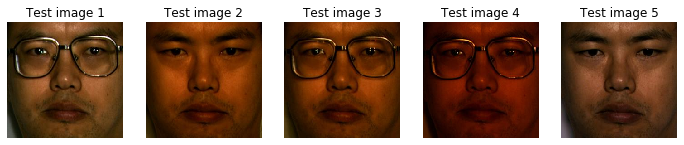

In [2]:
# Get file paths to test images
fnames_test = sorted(glob.glob('images/test/*.jpg'))

plt.figure(figsize=(12,5))

for i in range(0,5):
    
    img = cv2.imread(fnames_test[i])
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display five test faces
    plt.subplot(1,5,i+1)
    plt.imshow(rgb)
    plt.title('Test image %d' %(i+1))
    plt.axis('off')

All of these faces correspond to the face 1. Notice that the color of the face varies greatly depending on the lighting conditions. Instead of relying on the color information, we will perform the classification using either the grayscale or LBP histograms. 

## 2. Histogram-based distance

To classify a face, we must determine the distance to each of the training histograms `H`. Let us pick one test image and compute its grayscale histogram `h`.

Text(0.5, 1.0, 'Grayscale histogram')

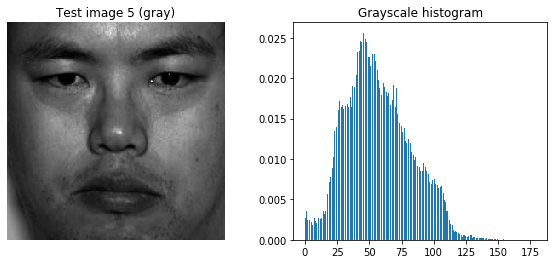

In [3]:
img = cv2.imread(fnames_test[4])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.title('Test image 5 (gray)')
plt.axis('off')
plt.subplot(122)
h = plt.hist(gray.ravel(),256,density=True)[0]
plt.title('Grayscale histogram')

**2.1. Compute $L_1$ distances** $\quad$ <font color=red>(0.50 points)</font>

We need to measure the similarity between two histograms $H_i$ and $h$. There exists various distance measures that can be used. We will use the $L_1$ distance:

$$
L_1(H_i,h) = \sum_{m=1}^{K} |H_i(m) - h(m)|, \qquad \qquad (1)
$$

where $K$ is the number of bins. Complete the following code cell. The function `histogramDistance()` should compute $L_1$ distances between a test histogram `h` and each training histogram `H[i,:]`. The function should return a vector of distances `dists`. Make sure that the function works with arbitrary length histograms (not just histograms with length K=256).

In [13]:
# INPUT   
# H : Training histograms (5xK matrix)
# h : Test histogram (1xM vector)
#
# OUTPUT  
# dists: L1 distances between a test histogram
#        and each training histogram (5x1 vector)
#
def histogramDistances(H,h):
    
    # ---------- YOUR CODE STARTS HERE -----------
    
    # The following line can be removed
    # dists = np.zeros(H.shape[0],dtype=float)
    
    dists = np.abs(H - h)
    dists = np.sum(dists,axis=1)
    
    # ----------- YOUR CODE ENDS HERE ------------

    return dists

# Compute L1 distances
dists = histogramDistances(H,h)
print('L1 distances:')
print(dists)


L1 distances:
[1.02348424 1.21748245 1.03130705 1.23614375 1.4938191 ]


In [35]:
assert histogramDistances(np.ones(H.shape)*-1, np.ones(h.shape))[0] == histogramDistances(np.ones(H.shape)*3, np.ones(h.shape))[0], "The histogramDistances() function seems to wrong."
assert histogramDistances(np.ones(H.shape)*0, np.ones(h.shape))[0] == 256, "The histogramDistances() function seems to wrong."
assert histogramDistances(np.ones(H.shape)*1, np.ones(h.shape))[0] == 0, "The histogramDistances() function seems to wrong."
assert histogramDistances(np.ones(H.shape)*2, np.ones(h.shape))[0] == 256, "The histogramDistances() function seems to wrong."



**Hint!**
- Your implementation should be correct if the distances are close to: [1.02 1.21 1.03 1.23 1.49].

Next we are going to classify the test face based on the histogram distances.

In [36]:
# Predict class (face)
pred = np.argmin(dists)
dist = dists[pred]
print('\nPredicted face: %d (dist = %f)' %(pred+1,dist))


Predicted face: 1 (dist = 1.023484)


The first training histogram is the most similar to `h`. Therefore, the given face corresponds to the face 1. The classification is correct, however, the distance to the third training histogram (face 3) was also small. The face was almost misclassified.

## 3. Face recognition using grayscale histograms

In the previous section, we classified a single face by comparing grayscale histograms. Next, we will classify all test images. We will also build a confusion matrix $C$ to report the classification results. In the confusion matrix, the entry $C(i,j)$ shows how many times an object (face) was classified as class $j$ when the true class was $i$. The confusion matrix might look like:

$$
C(i,j) = 
 \begin{pmatrix}
  10 & 0 & 0 & 0 & 0 \\
  0 & 9 & 0 & 1 & 0 \\
  0 & 0 & 10 & 0 & 0 \\
  0 & 0 & 0 & 10 & 0 \\
  0 & 0 & 0 & 0 & 10 
 \end{pmatrix}
$$

Elements along the diagonal represent correct classifications and off-diagonal elements are misclassifications. In the previous example, the result is almost perfect. The entry $C(2,4)=1$ indicates that a face was once classified to class 4 when the true class was 2.

**3.1. Classify faces using grayscale histograms** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. You should classify all the test faces. 

In [42]:
# Confusion matrix
C = np.zeros((N,N),dtype=int)

for fname in fnames_test:

    # Extract the true class from the file name
    i = int(fname[-8]) - 1
    
    # Read a test face
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # ---------- YOUR CODE STARTS HERE -----------
    
    # Compute histogram
    h = np.histogram(gray.ravel(),256,density=True)[0]
    
    # Compute L1 distances
    dists = histogramDistances(H,h)
    
    # Predict class (face)
    j = np.argmin(dists)
    
    # Record the result to the confusion matrix
    C[i,j] = C[i,j] + 1
    
    # ----------- YOUR CODE ENDS HERE ------------
    
print('Confusion matrix:')
print(C)

# Uncomment to compute the ratio of correct classifications
res = np.trace(C) / np.sum(C)
print('Score =', res)

Confusion matrix:
[[5 1 1 2 1]
 [2 2 5 0 1]
 [0 0 8 2 0]
 [1 0 5 3 1]
 [6 0 1 1 2]]
Score = 0.4


In [43]:
assert res >= 0.3
assert res <= 0.5

**Hints!**

- The code from Section 2.1. should help you to finish this task.
- Your implementation should be correct if you got a score 0.4 (or close).

**3.2. Which one of the faces was easiest to classify (based on the confusion matrix)?** $\quad$ <font color=red>(0.50 points)</font>

`REPLACE THIS TEXT WITH YOUR ANSWER.`


## 4. Face recognition using LBP histograms

Local Binary Patters (LBP) have been successfully applied to many computer vision problems. One reason they are so popular is that they are very fast and easy to compute. The LBP concept was originally conceived here in the University of Oulu. Computing the LBP for a pixel involves the 8 neighbours around it. Consider the neighbourhood around pixel $x$ as presented in Figure 2.

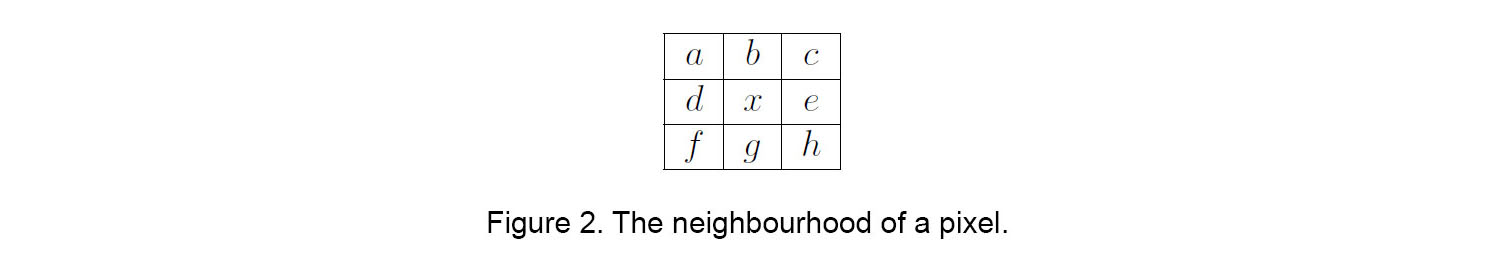

We threshold the values using $x$ as a threshold $(a_{th} = 1$ if $a \geq x)$, and then assign a bit to each neighbour. The final LBP for $x$ is

$$
L_x = 2^0a_{th} + 2^1b_{th} + 2^2c_{th} + 2^3d_{th} + 2^4e_{th} + 2^5f_{th} + 2^6g_{th} + 2^7h_{th},
$$

which is an 8 bit number. The LBP transform gives us a value for each pixel. To characterize a face we can compute the histogram of LBP values. This gives us a 1 x 256 feature vector that describes the face in a given image or patch. See the example (Lecture 5, Slide 26). The following function computes the LBP transform of a given image. The function also returns the LBP histogram.

(-0.5, 253.5, 253.5, -0.5)

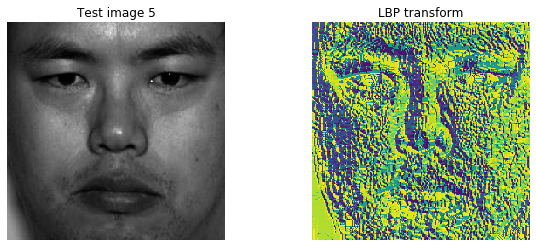

In [38]:
# INPUT   
# img : Input image (grayscale)
#
# OUTPUT  
# hist : LBP histogram (1x256 vector)
# out  : LBP transform of the input image
#
def LBP(img):
    m,n = img.shape
    out = np.zeros((m-2, n-2, 8), dtype=np.uint8)
    disp = ((-1, -1),(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1))
    center = img[1:-1, 1:-1]
    for i, d in enumerate(disp):
        out[:,:,i] = img[d[0] + 1 : d[0] + m - 1, d[1] + 1 : d[1] + n - 1] >= center
        out[:,:,i] = 2**i * out[:,:,i]
    out = np.sum(out, axis = 2)
    hist = np.histogram(out, 256, density=True)[0]
    return hist, out

img = cv2.imread(fnames_test[4])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h_lbp, img_lbp = LBP(gray)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.title('Test image 5')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_lbp)
plt.title('LBP transform')
plt.axis('off')

The process of detecting faces is the same as before: (1) Compute LBP histograms `H_lbp` of the training images. (2) Compute histogram distances between the training histograms `H_lbp`and test histogram `h_lbp`. Let us start by computing the LBP histograms of the training images.

In [39]:
# Compute LBP histograms of training faces
H_lbp = np.zeros((N,256),dtype=float)

for i in range(0,N):
    
    img = cv2.imread(fnames_train[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H_lbp[i,:] = LBP(gray)[0]

**4.1. Classify faces using LBP histograms** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. You should classify all the test faces using LBP histograms and report the classification results (print the confusion matrix). You can reuse the code from Section 3.1. Instead of computing grayscale histograms, compute LBP histograms using `LBP()` function.

In [45]:
# Confusion matrix
C = np.zeros((N,N),dtype=int)

# ---------- YOUR CODE STARTS HERE -----------

for fname in fnames_test:

    # Extract the true class from the file name
    i = int(fname[-8]) - 1
    
    # Read a test face
    img = cv2.imread(fname)
    
    # Convert to grayscale and compute the histogram
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h_lbp = LBP(gray)[0]
    #h = np.histogram(gray.ravel(),256,density=True)[0]

    # Compute L1 distances
    dists = histogramDistances(H_lbp,h_lbp)
    
    # Predict class (face)
    j = np.argmin(dists)
    
    # Record the result to the confusion matrix
    C[i,j] = C[i,j] + 1

    
# ----------- YOUR CODE ENDS HERE ------------
    
print('Confusion matrix:')
print(C)

# Uncomment to compute the ratio of correct classifications
res = np.trace(C) / np.sum(C)
print('Score =', res)



Confusion matrix:
[[6 0 0 1 3]
 [1 5 2 0 2]
 [1 1 4 2 2]
 [1 0 0 7 2]
 [1 0 0 2 7]]
Score = 0.58


In [46]:
assert res >= 0.56
assert res <= 0.6

**Hint!**

- Your implementation should be correct if you got a score 0.58.

**4.2. Patch-based LBP**

The classification results did improve but they are still far from perfect. Instad of computing a single LBP histogram for the whole image, we will divide the image into 32 x 32 pixel patches. Since the image size is 256 x 256 pixels, this gives us exactly 64 patches as shown in Figure 3.

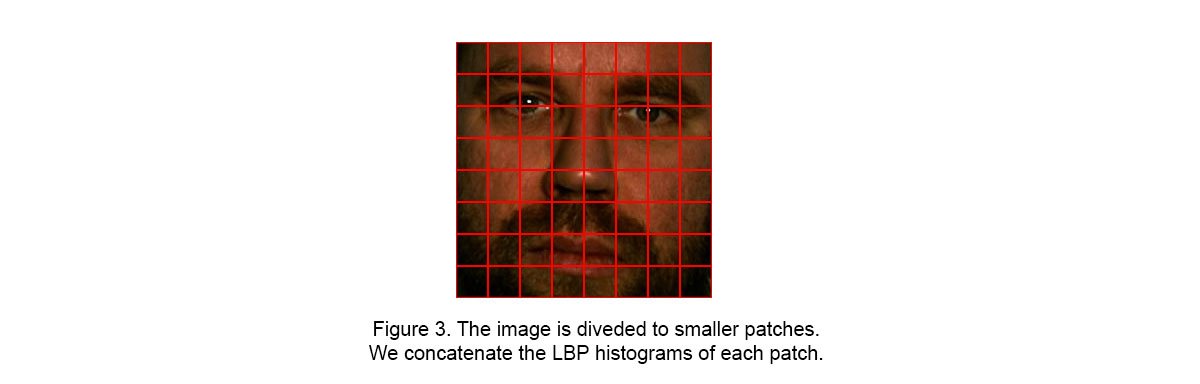

We will compute the LBP histogram of each patch and concatenate these into a single histogram (feature vector). The length of the histogram will be 16384 (8 x 8 x 256). Let us modify the `LBP()` function that was defined earlier.

In [47]:
# INPUT   
# img   : Input image (grayscale)
# psize : Patch size (32 pixels)
# bins  : Number of histogram bins (256)
#
# OUTPUT  
# hist : LBP histogram formed by concatenating
#        the histograms of individual patches.
#
def patchLBP(img,psize,bins):
    
    hist = []
    
    height,width = img.shape
    for y in range(0,height,psize):
        for x in range(0,width,psize):
            
            patch = img[y:y+psize,x:x+psize]
            m,n = patch.shape

            out = np.zeros((m-2, n-2, 8), dtype=np.uint8)
            disp = ((-1, -1),(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1))
            center = patch[1:-1, 1:-1]
            for i, d in enumerate(disp):
                out[:,:,i] = patch[d[0] + 1 : d[0] + m - 1, d[1] + 1 : d[1] + n - 1] > center
                out[:,:,i] = 2**i * out[:,:,i]
            out = np.sum(out, axis = 2)
            h = np.histogram(out, bins, density=True)[0]
            hist = np.concatenate((hist,h), axis=None)
            
    return hist

Again, the process of detecting faces is the same as before: (1) Compute patch-based LBP histograms of the training images `H_patch`. (2) Compute histogram distances between the training histograms `H_patch`and test histogram `h_patch`. We first compute the patch-based LBP histograms of the training images.

In [59]:
# Compute patch-based LBP histograms of training faces
H_patch = np.zeros((N,8*8*256),dtype=float)

psize = 32 # Patch size (32x32 pixels)
bins = 256 # Number of histogram bins

for i in range(0,N):
    
    img = cv2.imread(fnames_train[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H_patch[i,:] = patchLBP(gray,psize,bins)

**4.3. Classify faces (patch-based LBP)** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. You should classify all test faces using the patch-based LBP histograms and report the classification results (print confusion matrix). Again, you can reuse the code from Section 3.1. Instead of computing grayscale histograms, compute patch-based LBP histograms using `patchLBP()` function.

In [67]:
# Confusion matrix
C = np.zeros((N,N),dtype=int)

# ---------- YOUR CODE STARTS HERE -----------
for fname in fnames_test:

    # Extract the true class from the file name
    i = int(fname[-8]) - 1
    
    # Read a test face
    img = cv2.imread(fname)
    
    # Convert to grayscale and compute the histogram
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = patchLBP(gray,psize,bins)

    # Compute L1 distances
    dists = histogramDistances(H_patch,h)
    
    # Predict class (face)
    j = np.argmin(dists)
    
    # Record the result C[i,j] = C[i,j] + 1
    C[i,j] = C[i,j] + 1
    
# ----------- YOUR CODE ENDS HERE ------------    
    
print('Confusion matrix:')
print(C)

# Compute the ratio of correct classifications
res = np.trace(C) / np.sum(C)
print('Score =', res)



Confusion matrix:
[[10  0  0  0  0]
 [ 0 10  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 10]]
Score = 1.0


In [68]:
try:    
    assert res >= 0.98
except:
    print("The variable was named wrong. Please check it manually.")

**Hint!**

- Your implementation should be correct if you got a perfect score of 1.0 (or close).

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

# References
`LIST YOUR POSSIBLE REFERENCES HERE!`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A4.ipynb` file) into **`MV_A4_[student number(s)].zip`** (e.g. `MV_A4_1234567.zip` if solo work or `MV_A4_1234567-7654321.zip` if pair work).
3. Send an email to janne.mustaniemi@oulu.fi with the subject line `MV_A4_[student number(s)]`. Remember to attach the .zip file.

**Deadline of the assignment 12.2.2020**